# ASL Classification with a CNN

In [6]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-affuk_3k
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-affuk_3k
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82437 sha256=3a229d409eb9138088ff139872055f590483fa033fc3368baa0ca12f263731d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-tjlw71x6/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import numpy as np
#import keras

from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from glob import glob


# Get reproducible results
random_state = 46
tf.random.set_seed(random_state)

## GPU configuration
If you have a GPU, enable experimental memory growth.

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## File Paths

In [9]:
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/ECE 542/asl_alphabet_test"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
asl_alphabet_test


In [0]:
train_dir = "/content/drive/My Drive/ECE 542/asl_alphabet_train/asl_alphabet_train"
test_dir = "/content/drive/My Drive/ECE 542/asl_alphabet_test/asl_alphabet_test"
test_dir_rasband = "/content/drive/My Drive/ECE 542/asl_alphabet_rasbandtest"
best_model_path = "/content/drive/My Drive/ECE 542/4828_percent_acc.h5"

classnames = [folder[len(train_dir) + 1:] for folder in glob(train_dir + '/*')]
classnames.sort()

## Train model

In [0]:
def fit_model(model, train_generator, val_generator):
    sel_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=sel_optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()
    
    print('Fitting model...')
    history = model.fit(train_generator, 
        steps_per_epoch=300, 
        epochs=100, 
        verbose=1, 
        validation_data=val_generator, 
        validation_steps=5,
        use_multiprocessing=False,
        workers=8,
        callbacks=[
                tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path, monitor='val_accuracy', save_best_only = True),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience = 6, restore_best_weights = True)
            ])
    
    print('Evaluating model...')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    
    del model
    K.clear_session()

   

# models

In [12]:
imagesize = 48

datagen = ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    brightness_range = (0.5,2.0),
    rotation_range=5,
    #width_shift_range = 0.1,
    #height_shift_range = 0.1,
    validation_split=0.20)

testdatagen = ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    validation_split=0.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(imagesize, imagesize),
    batch_size=128,
    shuffle = True,
    class_mode='sparse',
)

val_generator = datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(imagesize, imagesize),
    batch_size=128,
    shuffle = True,
    class_mode='sparse',
)


Found 69632 images belonging to 29 classes.
Found 17404 images belonging to 29 classes.


Do Not Run if you are only loading a new model for plotting


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 64)      6976      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 128)       131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 58, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 55, 55, 128)       0

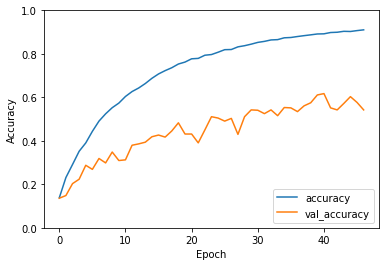

In [0]:
fit_model(tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (6,6), input_shape=(imagesize, imagesize, 3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (4,4), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (4,4), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, (2,2), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (2,2), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(29, activation='softmax')
]), train_generator, val_generator)

In [13]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools

model_path = best_model_path

model_uploaded = load_model(model_path)

test_generator = testdatagen.flow_from_directory(
    test_dir_rasband,
    target_size=(imagesize, imagesize),
    class_mode='sparse',
    batch_size = 1,
    shuffle=False
)


model_uploaded.evaluate(test_generator, verbose=1,steps=870)

predictions = model_uploaded.predict(test_generator, verbose = 1, steps = 870)

y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
predDict = dict(y_pred=y_pred, y_true=y_true)

print(classification_report(**predDict, target_names=classnames))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Found 870 images belonging to 29 classes.


ValueError: ignored

In [14]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**predDict, classes=classnames)

NameError: ignored